In [1]:
import glob 

In [2]:
list_of_graphs = glob.glob("../../subreddits/graphs/*/*.graphml")

true_categories = {
    list_of_graphs[i].split("\\")[-1].split(".")[0] : list_of_graphs[i].split("\\")[-2] for i in range(len(list_of_graphs))
}

In [15]:
# load the graphs

import networkx as nx

graphs = {}
files = glob.glob("../l2_graphs/*.graphml")

for file in files:
    with open(file, "r") as f:
        data = f.read()
        name = float(file.split("\\")[-1].split(".")[0] + '.' + file.split("\\")[-1].split(".")[1])
        graphs[name] = nx.parse_graphml(data)


In [4]:
import numpy as np
from collections import defaultdict, Counter

def get_homogeneity_scores(partition_dict):
    # Tracking node assignments across communities to identify overlaps
    node_assignments = defaultdict(list)
    for community_id, subreddits in partition_dict.items():
        for subreddit in subreddits:
            node = subreddit.split("\\")[-1]  # Extract the node identifier
            node_assignments[node].append(community_id)
    
    # Compute the most common category for each community
    most_common_category_dict = {}
    for community_id, subreddits in partition_dict.items():
        categories = [true_categories[subreddit.split("\\")[-1].split(".")[0]] for subreddit in subreddits if subreddit.split("\\")[-1].split(".")[0] in true_categories]
        category_counts = Counter(categories)
        if category_counts:
            most_common_category, _ = category_counts.most_common(1)[0]
            most_common_category_dict[community_id] = most_common_category
        else:
            most_common_category_dict[community_id] = None  # No valid category found

    # Calculate the homogeneity for each community using weighted contributions
    homogeneity_scores = {}
    for community_id, subreddits in partition_dict.items():
        categories = []
        weights = []
        for subreddit in subreddits:
            node = subreddit.split("\\")[-1]
            if node in true_categories:
                category = true_categories[node]
                categories.append(category)
                # Weight inversely proportional to correct community assignments
                if category == most_common_category_dict[community_id]:
                    correct_assignments = [cid for cid in node_assignments[node] if true_categories[node] == most_common_category_dict[cid]]
                    weights.append(1 / len(correct_assignments) if correct_assignments else 1)
                else:
                    weights.append(1)
        
        category_counts = Counter(categories)
        if category_counts:
            most_common_category, _ = category_counts.most_common(1)[0]
            weighted_counts = sum(w for cat, w in zip(categories, weights) if cat == most_common_category)
            homogeneity = weighted_counts / sum(weights) if sum(weights) > 0 else 0
        else:
            homogeneity = 0
        
        homogeneity_scores[community_id] = homogeneity
    
     # Calculate mean and median homogeneity
    mean_homogeneity = np.mean(list(homogeneity_scores.values())) if homogeneity_scores else 0
    median_homogeneity = np.median(list(homogeneity_scores.values())) if homogeneity_scores else 0
    
    return mean_homogeneity, median_homogeneity


In [5]:
def remove_outliers(partition_dict):
    temporary_partition_dict = partition_dict.copy()
    community_sizes = np.array([len(v) for v in partition_dict.values() if len(v) > 1])
    Q1 = np.percentile(community_sizes, 25)
    Q3 = np.percentile(community_sizes, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    partition_dict = {k: v for k, v in partition_dict.items() if len(v) >= lower_bound and len(v) <= upper_bound and len(v) > 1}
    return partition_dict, temporary_partition_dict

In [6]:
def validate_partition(G, partition):
    """ Ensure every node is covered exactly once in the partition. """
    all_nodes = set(G.nodes())
    covered_nodes = set()
    for community in partition:
        if not community:  # Skip empty communities if any
            continue
        community_set = set(community)
        if not covered_nodes.isdisjoint(community_set):
            raise ValueError("Overlap detected in communities")
        covered_nodes.update(community_set)

    if covered_nodes != all_nodes:
        raise ValueError("Partition does not cover all nodes")

In [11]:
from cdlib import algorithms
# from cdlib.evaluation import modularity_overlap

def angel(G, threshold=0.90):
    communities = algorithms.angel(G, threshold=threshold)
    return {i: [com.split("\\")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

def demon(G, epsilon=0.60):
    communities = algorithms.demon(G, epsilon=epsilon)
    return {i: [com.split("\\")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities
algorithms_list = [angel, demon]

[<function angel at 0x000002100C6B9A80>, <function demon at 0x000002100C6B98A0>]


In [14]:
mean_homogeneity_scores = {
    algorithm: {} for algorithm in algorithms_list
}

modularity_scores = {
    algorithm: {} for algorithm in algorithms_list
}

median_homogeneity_scores = {
    algorithm: {} for algorithm in algorithms_list
}

for threshold, graph in graphs.items():
    for algorithm in algorithms_list:
        print(f"Running {algorithm.__name__} for threshold {threshold}")
        partition, communities = algorithm(graph)

        if len(partition) <= 1:
            print(f"{algorithm.__name__} for {threshold} has less than 1 partitions")
            continue 
        
        partition, original = remove_outliers(partition)
        mean_homogeneity, median_homogeneity = get_homogeneity_scores(partition)
        mean_homogeneity_scores[algorithm.__name__][threshold] = mean_homogeneity
        median_homogeneity_scores[algorithm.__name__][threshold] = median_homogeneity    

        # # calculate modularity for overlapping
        # mod = modularity_overlap(graph, communities)
        # modularity_scores[algorithm.__name__][threshold] = mod.score

Running angel for threshold 0.0001001001001001001


TypeError: expected non-empty vector for x

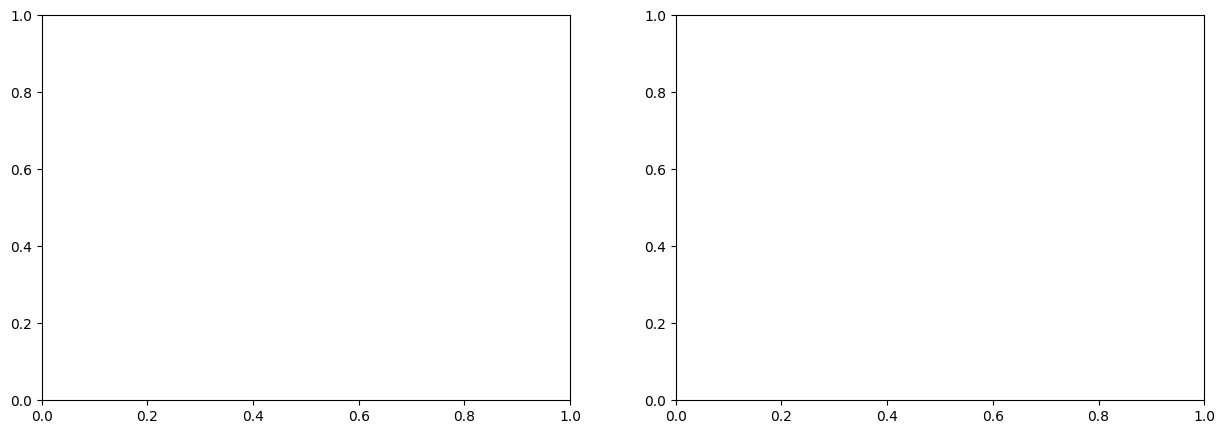

In [10]:
import matplotlib.pyplot as plt

def plot(data):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True, sharey=False)  # Removed sharey=True for different y scales
    algo_names = list(data.keys())
    axes = axes.flatten()  # Flatten the array of axes for easier iteration

    for idx, algo in enumerate(algo_names):
        thresholds = np.array(list(data[algo].keys()))
        homogeneities = np.array(list(data[algo].values()))
        modularities = np.array([modularity_scores[algo][threshold] for threshold in data[algo].keys()])

        # Sorting data for plotting
        sorted_indices = np.argsort(thresholds)
        thresholds = thresholds[sorted_indices]
        homogeneities = homogeneities[sorted_indices]
        modularities = modularities[sorted_indices]

        # Fit a smooth line for homogeneity
        z_homogeneity = np.polyfit(thresholds, homogeneities, 3)  # Cubic polynomial
        p_homogeneity = np.poly1d(z_homogeneity)
        smooth_homogeneities = p_homogeneity(thresholds)

        # Fit a smooth line for modularity
        z_modularity = np.polyfit(thresholds, modularities, 3)  # Cubic polynomial
        p_modularity = np.poly1d(z_modularity)
        smooth_modularities = p_modularity(thresholds)

        # Plotting each algorithm's homogeneity data
        axes[idx].scatter(thresholds, homogeneities, color='blue', label='Homogeneity Points')
        axes[idx].plot(thresholds, smooth_homogeneities, 'r-', label='Smooth Homogeneity Curve')

        # Plotting each algorithm's modularity data
        axes[idx].plot(thresholds, modularities, 'g^', label='Modularity Points')
        axes[idx].plot(thresholds, smooth_modularities, 'g--', label='Smooth Modularity Curve')
        max_homogeneity = max(homogeneities)
        max_index = np.argmax(homogeneities)
        max_threshold = thresholds[max_index]
        axes[idx].scatter(max_threshold, max_homogeneity, color='red', edgecolor='black', zorder=5)  # Higher zorder to draw on top
        axes[idx].annotate(f'{max_homogeneity:.4f}', (max_threshold, max_homogeneity),
                           textcoords="offset points", xytext=(0,10), ha='center')

        axes[idx].set_title(algo)
        axes[idx].set_xlabel('Threshold')
        axes[idx].set_ylabel('Scores')
        axes[idx].legend()

    plt.tight_layout()
    plt.show()


plot(mean_homogeneity_scores)
plot(median_homogeneity_scores)

In [ ]:
from cdlib import algorithms
# from cdlib.evaluation import modularity_overlap

def slpa(G, r=0.1):
    communities = algorithms.slpa(G, r=r)
    return {i: [com.split("\\")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

def multicom(G):
    communities = algorithms.multicom(G, seed_node=0)
    return {i: [com.split("\\")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities


algorithms_list = [slpa, multicom]

mean_homogeneity_scores = {
    algorithm: {} for algorithm in algorithms_list
}

modularity_scores = {
    algorithm: {} for algorithm in algorithms_list
}

median_homogeneity_scores = {
    algorithm: {} for algorithm in algorithms_list
}

for threshold, graph in graphs.items():
    for algorithm in algorithms_list:
        print(f"Running {algorithm.__name__} for threshold {threshold}")
        partition, communities = algorithm(graph)

        if len(partition) <= 1:
            print(f"{algorithm.__name__} for {threshold} has less than 1 partitions")
            continue 
        
        partition, original = remove_outliers(partition)
        mean_homogeneity, median_homogeneity = get_homogeneity_scores(partition)
        mean_homogeneity_scores[algorithm.__name__][threshold] = mean_homogeneity
        median_homogeneity_scores[algorithm.__name__][threshold] = median_homogeneity    

        #  # calculate modularity for overlapping
        # mod = modularity_overlap(graph, communities)
        # modularity_scores[algorithm.__name__][threshold] = mod.score

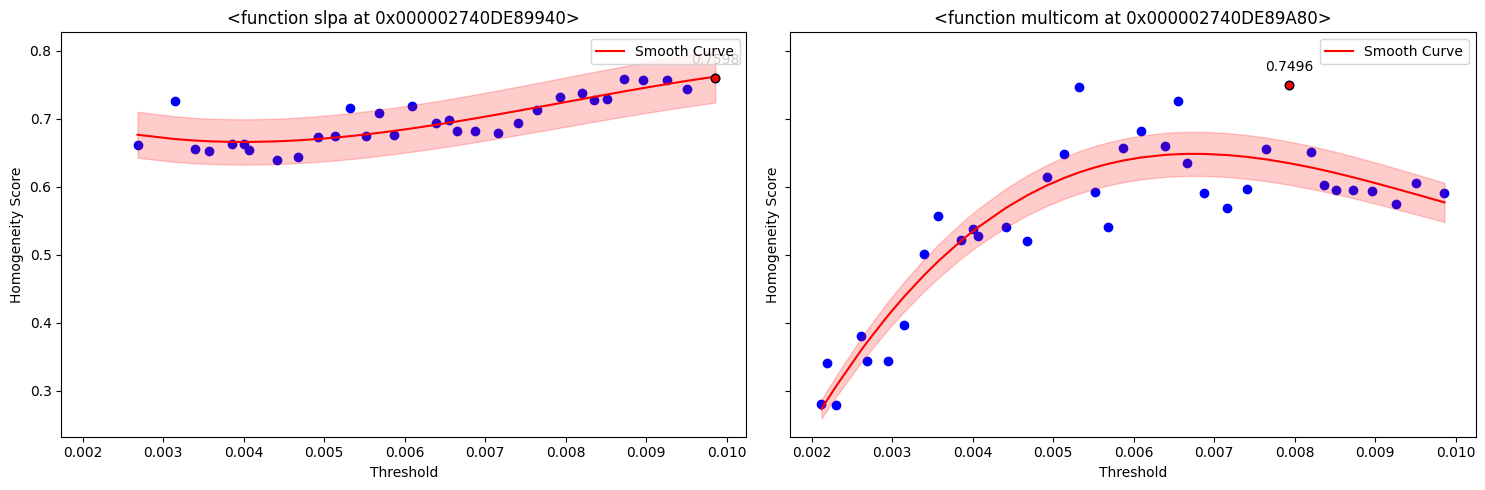

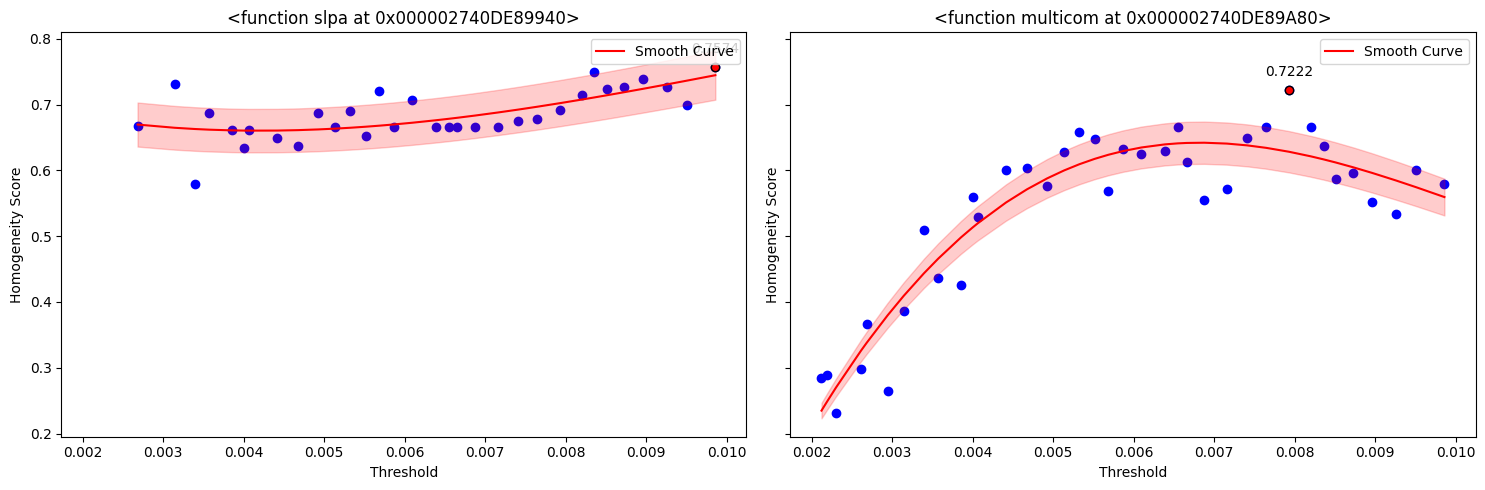

In [ ]:
plot(mean_homogeneity_scores)
plot(median_homogeneity_scores)


In [ ]:
from cdlib import algorithms
# from cdlib.evaluation import modularity_overlap

def graph_entropy(G, weights="weight"):
    communities = algorithms.graph_entropy(G, weights=weights)
    return {i: [com.split("\\")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

def core_expansion(G):
    communities = algorithms.core_expansion(G)
    return {i: [com.split("\\")[-1].split(".")[0] for com in comm] for i, comm in enumerate(communities.communities)}, communities

algorithms_list = [graph_entropy, core_expansion]

mean_homogeneity_scores = {
    algorithm: {} for algorithm in algorithms_list
}

modularity_scores = {
    algorithm: {} for algorithm in algorithms_list
}

median_homogeneity_scores = {
    algorithm: {} for algorithm in algorithms_list
}

for threshold, graph in graphs.items():
    for algorithm in algorithms_list:
        print(f"Running {algorithm.__name__} for threshold {threshold}")
        partition, communities = algorithm(graph)

        if len(partition) <= 1:
            print(f"{algorithm.__name__} for {threshold} has less than 1 partitions")
            continue 
        
        partition, original = remove_outliers(partition)
        mean_homogeneity, median_homogeneity = get_homogeneity_scores(partition)
        mean_homogeneity_scores[algorithm.__name__][threshold] = mean_homogeneity
        median_homogeneity_scores[algorithm.__name__][threshold] = median_homogeneity    

        # calculate modularity for overlapping
        # mod = modularity_overlap(graph, communities)
        # modularity_scores[algorithm.__name__][threshold] = mod.score


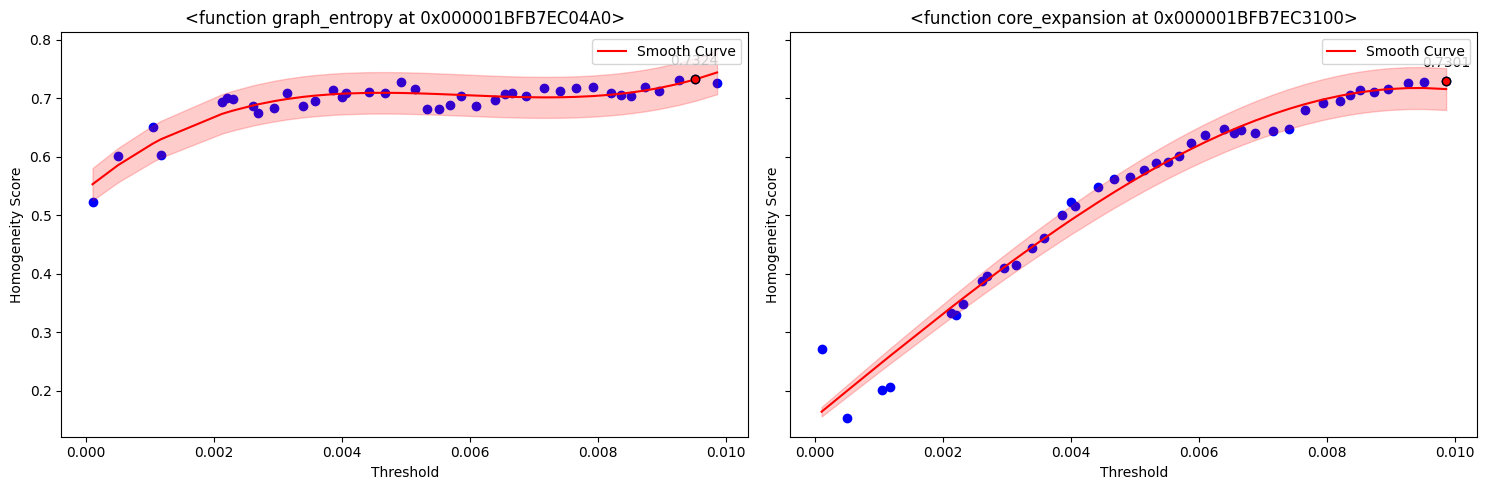

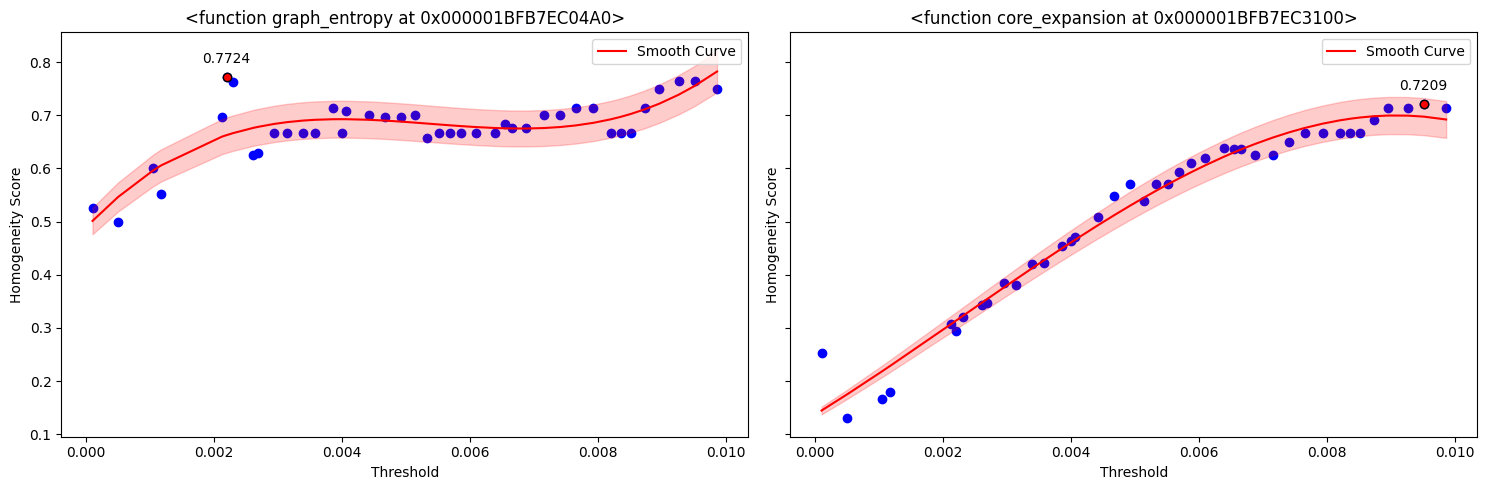

In [ ]:
plot(mean_homogeneity_scores)
plot(median_homogeneity_scores)